In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import io
import multiprocessing
import random
from functools import partial

from FF.image_processing import thresh, prepare_scalemap, edgedetector, measure_D
from FF.fractal_generation import midpoint_displacement, mountainpro, branching_network


import warnings
warnings.filterwarnings("ignore", category=UserWarning)



def generate_coastline(D, iterations, P = 1):
        
        meshmap = midpoint_displacement(iterations, P = P, D=D)
        scalemap = prepare_scalemap(meshmap)
        threshmap, bwratio = thresh(scalemap, iterations)
        coastline = edgedetector(threshmap, iterations)
        return threshmap, coastline

def generate_mountain(D, iterations, P = 1, zslice = 0.5):
        meshmap = midpoint_displacement(iterations, P = P, D=D)
        scalemap = prepare_scalemap(meshmap)
        slice, mountain = mountainpro(scalemap, iterations, zslice)
        return (1-slice)*255, mountain * 255

def generate_branch_network(network_params, neuron_params):

    network = branching_network.generate_network(network_params=network_params, neuron_params=neuron_params)    
    network_masks = network.generate_binary_mask()
    network_mask_filled = network_masks['filled']
    network_mask_outline = network_masks['outline']

    return network_mask_filled, network_mask_outline

def generate_and_save_fractal(fractal_type, target_D, params, neuron_params, network_params, output_dir, tolerance, max_attempts, save_fractal):
    """
    Generates a single fractal based on the specified type and parameters,
    saves it if it meets the tolerance criteria, and returns its details.
    """
    
    seed = (os.getpid() + int(target_D * 1000)) % (2**32 - 1)
    np.random.seed(seed)
    random.seed(seed)
    
    adjusted_D = target_D
    attempts = 0
    generated = 0

    if fractal_type == 'branch network':
        adjusted_mean_branches = neuron_params.get('mean_branches', 1.5)
        adjusted_n_primary_dendrites = neuron_params.get('n_primary_dendrites', 3)
        adjusted_num_neurons = network_params.get('num_neurons', 10)
        adjusted_branch_angle = neuron_params.get('branch_angle', np.pi / 4)
        
        # Make copies to avoid modifying the original dictionaries
        neuron_params = neuron_params.copy()
        network_params = network_params.copy()

    while generated < 1 and attempts < max_attempts:
        try:
            if fractal_type == 'coastline':
                image, fractal = generate_coastline(adjusted_D, params['iterations'], params['P'])
            elif fractal_type == 'mountain':
                image, fractal = generate_mountain(adjusted_D, params['iterations'], params['P'], params['zslice'])
            elif fractal_type == 'branch network':
                neuron_params['D'] = adjusted_D
                neuron_params['mean_branches'] = adjusted_mean_branches
                neuron_params['n_primary_dendrites'] = adjusted_n_primary_dendrites
                neuron_params['branch_angle'] = adjusted_branch_angle
                network_params['num_neurons'] = adjusted_num_neurons

                image, fractal = generate_branch_network(network_params, neuron_params)
                fractal = (fractal * 255).astype(np.uint8)
                image = (image * 255).astype(np.uint8)
            else:
                return None  # Invalid fractal type

            D_measured = measure_D(fractal, min_size=8, max_size=np.shape(fractal)[0]//5, n_sizes=20, invert=False)

            if abs(D_measured - target_D) <= tolerance:
                # Create unique filenames to avoid conflicts
                image_filename = f"{fractal_type}_image_{D_measured:.5f}.tif"
                image_path = os.path.join(output_dir, image_filename)
                io.imsave(image_path, image.astype(np.uint8))
                
                if save_fractal:
                    fractal_filename = f"{fractal_type}_fractal_{D_measured:.5f}.tif"
                    fractal_path = os.path.join(output_dir, fractal_filename)
                    io.imsave(fractal_path, fractal.astype(np.uint8))
                
                return (os.path.basename(image_path), D_measured, fractal_type)
            else:
                attempts += 1
                if fractal_type in ['coastline', 'mountain']:
                    if fractal_type == 'coastline' and attempts % 5 == 0:
                        adjusted_D += 0.01 if D_measured < target_D else -0.01
                    elif fractal_type == 'mountain' and attempts % 2 == 0:
                        adjusted_D += 0.02 if D_measured < target_D else -0.01
                elif fractal_type == 'branch network' and attempts % 5 == 0:
                    if D_measured < target_D:
                        adjusted_D += 0.01
                        adjusted_mean_branches += 0.1
                        adjusted_n_primary_dendrites += 1
                        adjusted_num_neurons += 1
                        adjusted_branch_angle += np.pi / 180
                    else:
                        adjusted_D -= 0.01
                        adjusted_mean_branches -= 0.1
                        adjusted_n_primary_dendrites -= 1
                        adjusted_num_neurons -= 1
                        adjusted_branch_angle -= np.pi / 180
        except Exception as e:
            print(f"Error generating {fractal_type} fractal with target D {target_D}: {e}")
            return None

def batch_generate_fractals_multi_forced(num_fractals_per_type, 
                                         iterations, 
                                         D_ranges, 
                                         P,
                                         fractal_types=['coastline', 'mountain', 'branch network'],
                                         output_dir='/home/apd/Projects/FractalFluency/datasets/data_dump',
                                         neuron_params=None,
                                         network_params=None,
                                         zslice=0.5,
                                         tolerance=0.05,
                                         max_attempts=100,
                                         save_fractal=False):
    
    os.makedirs(output_dir, exist_ok=True)
    data = []
    skipped = 0

    # Prepare parameters dictionary to pass to helper function
    params = {
        'iterations': iterations,
        'P': P,
        'zslice': zslice
    }

    # Create a list of tasks
    tasks = []
    for fractal_type in fractal_types:
        D_range = D_ranges.get(fractal_type, None)
        assert D_range is not None, f"D_range must be provided for fractal type '{fractal_type}', should be tuple (D_min, D_max), e.g. (1.2, 1.6)"
        
        min_D, max_D = D_range
        D_values = np.linspace(min_D, max_D, num_fractals_per_type)

        for target_D in D_values:
            tasks.append((
                fractal_type, 
                target_D, 
                params, 
                neuron_params if neuron_params else {}, 
                network_params if network_params else {}, 
                output_dir, 
                tolerance, 
                max_attempts, 
                save_fractal
            ))

    # Initialize a Pool with the number of available CPU cores
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        # Use tqdm to display a progress bar with pool.starmap
        results = list(tqdm(pool.starmap(generate_and_save_fractal, tasks), total=len(tasks), desc="Generating fractals", unit="fractal"))

    # Process results
    for result in results:
        if result:
            data.append(result)
        else:
            skipped += 1

    # Save the results to a CSV file
    csv_file = os.path.join(output_dir, 'labels.csv')
    df = pd.DataFrame(data, columns=['filename', 'd_value', 'fractal_type'])
    df.to_csv(csv_file, index=False)

    total_fractals = len(data)
    print(f'\nBatch generation complete, with {skipped} skipped. \n{total_fractals} fractals saved to {output_dir}.')
    print(f'Labels saved to {csv_file}.')

# Ensure that the main execution is guarded
if __name__ == "__main__":
    # Define the parameters for fractal generation
    num_fractals_per_type = 100  # Number of fractals to generate per fractal type
    iterations = 9              # Number of iterations for fractal generation algorithms
    P = 1                       # Parameter controlling randomness in the generation
    zslice = 0.5                # Z-slice value for mountain fractal generation
    tolerance = 0.02            # Acceptable difference between measured D and target D
    max_attempts = 100          # Maximum attempts to reach the target D for each fractal
    output_dir = '/home/apd/Projects/FractalFluency/datasets/new_test'  # Directory to save generated fractals

    # Define the fractal types you want to generate
    fractal_types = ['branch network','mountain', 'coastline']

    # Define the D_ranges for each fractal type
    D_ranges = {
        'coastline': (1.2, 1.8),
        'mountain': (1.2, 1.6),
        'branch network': (1.2, 1.8)
    }

    # Define neuron parameters for 'branch network' fractals
    neuron_params = {
        'depth': 5,
        'mean_soma_radius': 0,
        'std_soma_radius': 0,
        'D': None,
        'branch_angle': np.pi / 4,
        'mean_branches': 1.5,
        'weave_type': 'Gauss',
        'randomness': 0.2,
        'curviness': 'Gauss',
        'curviness_magnitude': 1.5,
        'n_primary_dendrites': 5,
        'total_length': 400,
        'initial_thickness': 20
    }

    # Define network parameters for 'branch network' fractals
    network_params = {
        'num_neurons': 10,
        'width': 2048,
        'height': 2048,
        'edge_margin': 200
    }

    # Call the function
    batch_generate_fractals_multi_forced(
        num_fractals_per_type=num_fractals_per_type,
        iterations=iterations,
        D_ranges=D_ranges,
        P=P,
        fractal_types=fractal_types,
        output_dir=output_dir,
        neuron_params=neuron_params,
        network_params=network_params,
        zslice=zslice,
        tolerance=tolerance,
        max_attempts=max_attempts,
        save_fractal=True  # Set to True if you want to save fractal images
    )


Error generating branch network fractal with target D 1.7212121212121212: scale < 0


Generating fractals: 100%|██████████| 300/300 [00:00<00:00, 1800130.47fractal/s]


Batch generation complete, with 1 skipped. 
299 fractals saved to /home/apd/Projects/FractalFluency/datasets/new_test.
Labels saved to /home/apd/Projects/FractalFluency/datasets/new_test/labels.csv.


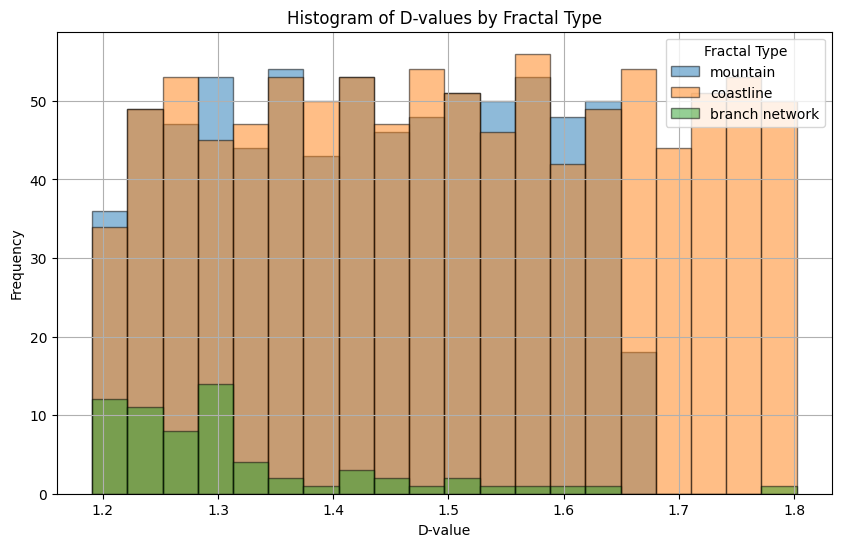

In [11]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the path to the directory containing fractal images
directory_path = '/home/apd/Projects/FractalFluency/datasets/new_test'

# Initialize lists to store D values and fractal types
d_values = []
fractal_types = []

# Loop through files in the directory and extract fractal type and D value
for filename in os.listdir(directory_path):
    if 'fractal_' in filename:
        # Extract fractal type and D value using regex
        type_match = re.match(r'^(.*)_fractal_(\d\.\d+)', filename)
        if type_match:
            fractal_type = type_match.group(1).strip()  # e.g., 'coastline', 'branch network', 'mountain'
            d_value = float(type_match.group(2))  # D value
            fractal_types.append(fractal_type)
            d_values.append(d_value)

# Function to plot histogram with legend for fractal types
def hist_train_data(d_values, fractal_types, bins=20, stacked=False):
    # Create a DataFrame from the provided d_values and fractal_types
    data = pd.DataFrame({
        'd_value': d_values,
        'fractal_type': fractal_types
    })

    unique_types = data['fractal_type'].unique()
    plt.figure(figsize=(10, 6))

    # Prepare the list of d_values for each fractal type
    hist_data = [data[data['fractal_type'] == ftype]['d_value'] for ftype in unique_types]

    # Compute consistent bins across all fractal types
    min_val = np.min(d_values)
    max_val = np.max(d_values)
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    if stacked:
        # Plot stacked histogram
        plt.hist(
            hist_data,
            bins=bin_edges,  # Use consistent bin edges
            stacked=True,
            alpha=0.7,
            label=[str(ftype) for ftype in unique_types],
            edgecolor='black'
        )
        plt.title('Stacked Histogram of D-values by Fractal Type')
    else:
        # Plot histograms side by side (overlay with transparency)
        for idx, ftype in enumerate(unique_types):
            plt.hist(
                hist_data[idx],
                bins=bin_edges,  # Use consistent bin edges
                alpha=0.5,
                label=str(ftype),
                edgecolor='black'
            )
        plt.title('Histogram of D-values by Fractal Type')

    plt.xlabel('D-value')
    plt.ylabel('Frequency')
    plt.legend(title='Fractal Type')
    plt.grid(True)
    plt.show()

# Call the function with extracted d_values and fractal_types
hist_train_data(d_values, fractal_types, bins=20, stacked=False)
